# Working with 3D molecules in RDKit

This notebook shows the procedure followed to work rdkit along with molecules obtained from crystalographic or docking poses. Therefore, the idea is to correctly load the molecule with rdkit while preserving the original 3D structure.

In [1]:
import numpy as np
import pandas as pd
import pytraj as pyt
import glob, os

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [17:45:35] Enabling RDKit 2019.09.1 jupyter extensions


### First we load the CDK2 data table
**The `df_cdk2_labels` table includes information related to the 402 conformations of the CDK2 protein, their respective ligand information (if applies), and the conformation labels which indicate if the protein is in an active or inactive conformation.** 

In [3]:
# Nombre de la proteina de interes
prot_name = 'cdk2'
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS_AUC_docking_DUD.json')))[0]
df_cdk2_labels = pd.read_json(path_to_json_file)

### Formato de las moléculas
---
<div style='background-color: #F5A566; padding: 5px 12px;'>Antes de cargar las moléculas, debemos convertirlas a un formato que sea correctamente leído con rdkit.</div>

**Para ello en necesario considerar lo siguiente:**

Los archivos pueden ser leídos a partir de dos fuentes:
1. **_`sdf`_ desde un pdb_:** Desde un archivo _pdb_ sin Hs (como las poses de los ligandos cocristalizados con proteínas), usando: `obabel -ipdb file.pdb -osdf file.sdf -p 7.4`
2. **_`sdf`_ desde un mol2:** Desde el archivo _mol2_ generado con `Chimera` que ya ha sido protonado con este mismo programa, usando: `obabel -imol2 file.mol2 -osdf file.sdf`. Es importante no usar el parámetro `-p`

```bash
# Usamos obabel 
cd "../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP"
for mol in `ls *pdb`
do 
    name=${mol%.*}
    # Directamente desde el archivo pdb sin Hs
    obabel -ipdb $mol -osdf -O ${name}_from_pdb.sdf -p 7.4 # Añade Hs a ph fisiológico
done

mv *sdf ../LIGS_POSES_SDF/

cd "../LIGS_PREP_IN_POCKET"
for mol in `ls *mol2`
do 
    name=${mol%.*}
    # directamente desde el archivo mol2 generado con chimera y sin el parámetro -p
    obabel -imol2 $mol -osdf -O ${name}_from_mol2.sdf
done

mv *sdf ../LIGS_POSES_SDF/
```

> **NOTA:** Cuando la molécula provenga desde un archivo *pdbqt* o *pdb* de docking, el proceso para obtener los archivos superiores es primero remover los hidrógenos de la molécula y luego añadirlos con `Chimera` o `babel` (este equivale al mismo proceso utilizado antes del docking para preparar las moléculas). Finalmente se guardará la molécula en un archivo **`mol2`** que correspoonde al solicitado en el punto #1 de la lista anterior.

## Ligandos cocristalizados
### Las moléculas son cargadas en formato SDF
**Se genera lista con los _paths_ de los archivos cocristalizados.**

In [4]:
path_crys_poses = "../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS_PREP_SDF/".split('/')
files_pose_crys = sorted( glob.glob(os.path.join(*path_crys_poses) 
                                    + "*_from_pdb.sdf") ) # Ligandos generados con chimera
# El número de ligandos a evaluar
print(F'Número de archivos de ligandos a cargar: {len(files_pose_crys)}')

Número de archivos de ligandos a cargar: 365


### Cargamos las moléculas con *rdkit*
Usamos el siguiente bloque de código que emplea el método `Chem.SDMolSupplier` de `rdkit` para cargar cada uno de los ligandos cocristalizados con la proteína.

<br>
<div class='bg-info', style='padding: 10px;'>
Por lo que se ha analizado hasta ahora, <span style='font-weight: bold;'> desde un archivo mol2 no funcionará</span>  si la molécula tiene ciclos que no siguen el estándar de corina ('C.ar' o 'N.ar'), u oxígenos unidos a fósforo debido a que rdkit no reconoce los Oxígenos O.c2 en archivos mol2 generados por babel o Chimera (formatos distintos al estándar 'corina' que sigue rdkit).<br>El problema no parece poder resolverse sustituyendo, por ejemplo, 'C.ar' por 'C.2', pues manualmente hay que elegir qué átomos deben tener un enlace <i>sp2</i> (C=C) o sp3 (C-C) dentro del ciclo.<a> src='https://sourceforge.net/p/rdkit/mailman/message/28665746/'>Fuente</a>.
</div>

Para ello se crea un diccionario con los objetos correspondientes a cada molécula.


In [5]:
# Cargamos los ids y nombre de los ligandos ordenados en una lista
pdbId_lig_dic = {file.split("/")[-1].split("_")[0]: file.split("/")[-1].split("_")[1] 
               for file in files_pose_crys}

<div style='background-color: #F9E5AB; padding: 5px 12px; font-size: 1.2em;'>El proceso de carga de las moléculas es el siguiente:</div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #F5B75D; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Se intenta cargar desde el archivo sdf generado a partir del pdb original con obabel.</span>
    Esto resuleve el problema con los archivos mol2, y garantiza que la carga de los grupos fosfato sea respetada. A cambio, este paso genera problemas de valencia en átomos de N y C dentro de ciclos debido a que la conectividad de éstos no es correctamente interpretada. <i>De no ser por los fosfatos, podríamos saltar de este paso al siguiente</i>.
    </li>
      <li class="list-group-item"><span style='background-color: #F5975D; padding: 5px;'>2)</span>
      <span style='font-weight: bold;'>Se intenta cargar desde el archivo sdf generado a partir del mol2 con Hidrógenos.</span>
    Este paso resuelve el probela del anterior.
    </li>
     <li class="list-group-item"><span style='background-color: #EB624C; padding: 5px;'>3)</span>
      <span style='font-weight: bold;'>Se intenta cargar desde el archivo sdf generado a partir del mol2 con Hidrógenos pero sin sanitizar la molécula.</span>
    En este punto el problema del punto 2) no se resuelve en el paso 3) con lo cual aún existen átomos con una valencia inadecuada (carbonos pentavalentes o nitrógenos hexavalentes), con lo cual se fuerza a rdkit a no sanitizar la molécula y se usa <code>UpdatePropertyCache(strict=False)</code> que permite reestablecer las propiedades de la molécula, como la valencia y la información de los anillos, sin establecer los criterios estrictos usados al 'sanitizar' la molécula (<code>Chem.SanitizeMol()</code> ejecutado por defecto al cargar la molécula) esto permite poder calcular los descriptores WHIM sin levantar un error.
         (Refs: <a src='https://www.wildcardconsulting.dk/the-good-the-bad-and-the-ugly-rdkit-molecules/'>1</a>, <a src='https://www.wildcardconsulting.dk/the-good-the-bad-and-the-ugly-rdkit-molecules/'>2</a>).
    </li>
    </li>
</ol>

Cargamos los archivos en un diccionario cuyas claves correspondan al *PDB_ID* y los valores a la molécula cargada con *rdkit*.  
Adicionalmente otro diccionario que vincule el *PDB_ID* con el nombre de la molécula en el PDB.
> **NOTA:** El comando `%%capture` permite omitir el *output* con todos los *warnings* y errores que lanzará `rdkit` cada vez que un intento falle. Se deja activo sólo con la intención de reducir la longitud de este notebook.

In [6]:
%%capture
ligs_cdk2_dic = {}
ligs_validation_dic = {}

# Para cada molécula que será cargada con rdkit
for file in files_pose_crys:
    pdb_id = file.split("/")[-1].split("_")[0]
    # PRIMER INTENTO: carga el sdf generado directamente con babel a partir del pdb sin Hs.
    mol_list = Chem.SDMolSupplier(file, sanitize = True)
    ligs_cdk2_dic[pdb_id] = mol_list[0]
    ligs_validation_dic[pdb_id] = 'v1'
    # SEGUNDO INTENTO: se carga el sdf desde el mol2 generado con Chimera.
    if ligs_cdk2_dic[pdb_id] is None:
        file = file.replace('_pdb.sdf', '_mol2.sdf')
        mol_list = Chem.SDMolSupplier(file, sanitize = True)
        ligs_cdk2_dic[pdb_id] =  mol_list[0]
        ligs_validation_dic[pdb_id] = 'v2'
        # TERCER INTENTO: se omite a sanitización, este es el peor de los casos
        # porque hay que forzar a ser más laxo en la validación del compuesto
        if ligs_cdk2_dic[pdb_id] is None:
            # La molécula seguirá siendo leida desde el sdf generado a partir del mol2
            mol_list = Chem.SDMolSupplier(file, sanitize = False)
            mol = mol_list[0]
            mol.UpdatePropertyCache(strict = False)
            ligs_cdk2_dic[pdb_id] =  mol
            ligs_validation_dic[pdb_id] = 'v3'

Una vez cargadas las moléculas verificamos que sea posible calcular los descriptores a las moléculas.

In [7]:
errores = 0
for i, j in ligs_cdk2_dic.items():
    try:
        Chem.rdMolDescriptors.CalcWHIM(j)
    except(RuntimeError):
        errores += 1
        print('La molécula no fue cargada adecuadamente.')
print(F'Finalizado. {errores} moléculas dieron error al calcular sus descriptores.')

Finalizado. 0 moléculas dieron error al calcular sus descriptores.


### Comparación entre archivos SDF y PDB
Sólo a modo de ejemplo comparamos la misma molécula pero cargada a partir de un archivo PDB.

In [8]:
# Cargamos un archivo pdb como prueba
path_to_pdb_prueba = "../../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP/1b38_ATP_LIG.pdb".split('/')
_pdb_prueba = Chem.MolFromPDBFile(os.path.join(*path_to_pdb_prueba))

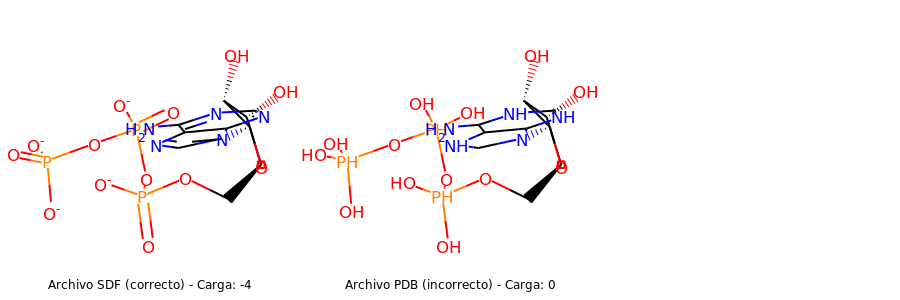

In [9]:
# visualización con rdkit
cargas_ = [Chem.rdmolops.GetFormalCharge(i) for i in [ligs_cdk2_dic['1b38'], _pdb_prueba]]
Chem.Draw.MolsToGridImage([ligs_cdk2_dic['1b38'], _pdb_prueba],
                         legends = [F'Archivo SDF (correcto) - Carga: {cargas_[0]}', 
                                    F'Archivo PDB (incorrecto) - Carga: {cargas_[1]}'],
                         subImgSize = (300, 300))

#### Visualización en 2d

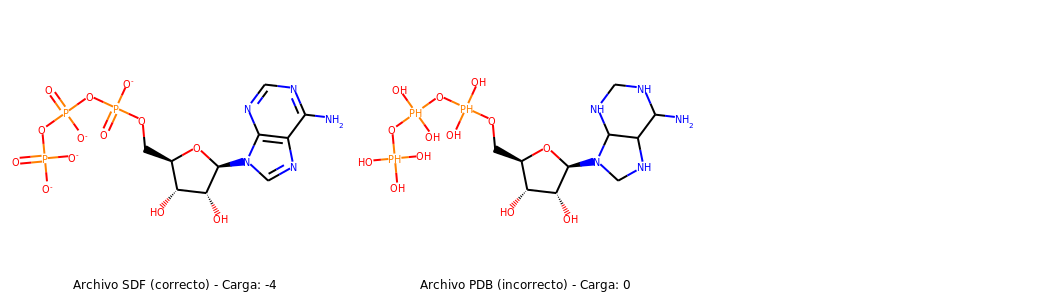

In [10]:
import copy
a_ = copy.copy(ligs_cdk2_dic['1fin']); b_ = copy.copy(_pdb_prueba)
for i in [a_, b_]: AllChem.Compute2DCoords(i)
Chem.Draw.MolsToGridImage([a_, b_],
                     legends = [F'Archivo SDF (correcto) - Carga: {cargas_[0]}', 
                                    F'Archivo PDB (incorrecto) - Carga: {cargas_[1]}'],
                     subImgSize = (350, 300))

La carga neta del **ATP** a pH 7.4 es de -3. [Ver fuente en Zinc15](http://zinc15.docking.org/substances/ZINC000004261765/)

## DataFrame con las Moléculas
#### Creamos un Dataframe a partir del diccionario.
En este punto se crea un **Dataframe** que permita vincular cada objeto de `rdkir` con el nombre de la molécula, el PDB id al que pertenece y al archivo del ligando.

In [11]:
# Lista de PDBIds y sus ligandos
df_crys_poses_rdk = pd.DataFrame.from_dict(pdbId_lig_dic, orient='index', columns=["Lig"])
# Se añaden las rutas a losarchivos pdb
df_crys_poses_rdk["mol_rdk"] = [i for i in ligs_cdk2_dic.values()]
df_crys_poses_rdk["file"] = files_pose_crys
df_crys_poses_rdk["Labels_conf"] = df_cdk2_labels.loc[pdbId_lig_dic.keys()].Labels_conf
df_crys_poses_rdk["Validation"] = ligs_validation_dic.values()
# Visualizamos parte del dataframe
df_crys_poses_rdk.head(5)

,Lig,mol_rdk,file,Labels_conf,Validation
1aq1,STU,<rdkit.Chem.rdchem.Mol object at 0x7f316c7bcb70>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_b,v1
1b38,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f316d504a80>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1b39,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f316c7bce90>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1ckp,PVB,<rdkit.Chem.rdchem.Mol object at 0x7f316c7bcf30>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1di8,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7f316c7bcf80>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1


Número de moléculas que no pudieron ser sanitizadas:

In [12]:
df_crys_poses_rdk.Validation.value_counts()

v1    212
v2    119
v3     34
Name: Validation, dtype: int64

### Guardamos el DataFrame

In [13]:
import pickle
n_molecules = len(df_crys_poses_rdk)
path_to_file_str = F'../data/rdkit_molecules/cdk2_{n_molecules}_cocristalized_ligands.pyobj'.split('/')
path_to_file = os.path.join(*path_to_file_str)

In [14]:
# Guardado del archivo
if not os.path.isfile(path_to_file):
    with open(path_to_file, 'wb') as f:
        pickle.dump(df_crys_poses_rdk, f)

In [15]:
# Carga del archivo
with open(path_to_file, 'rb') as f:
    df_crys_poses_rdk = pickle.load(f)

### Para accesar directamente a una molécula:

In [16]:
from rdkit.Chem import Descriptors, AllChem, Lipinski, rdMolDescriptors, rdFreeSASA
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate
from IPython.display import Image
import requests, copy

def get_ligand_image(protein_pdb_id):
    try: lig_name = df_crys_poses_rdk.loc[protein_pdb_id, 'Lig']
    except: 
        print(F'PDB ID {protein_pdb_id} no encontrado.')
        raise

    print(df_crys_poses_rdk.loc[protein_pdb_id, ['Lig', 'Labels_conf']])
    g = copy.copy(df_crys_poses_rdk.loc[protein_pdb_id, 'mol_rdk'])
    AllChem.Compute2DCoords(g)
    print('Peso molecular: %.3f' % Descriptors.ExactMolWt(g))
    print(F'Número de electrones de valencia: {Descriptors.NumValenceElectrons(g)} e')
    print('Volumen de la molécula: %.3f A^3' % AllChem.ComputeMolVolume(g))
    # Área de la superficie accesible al solvente
    radii1 = rdFreeSASA.classifyAtoms(g)
    print('SASA: %.3f A^2' % Chem.rdFreeSASA.CalcSASA(g, radii = radii1))
    # Descriptores de lipinski
    print(F'# de anillos: {Lipinski.RingCount(g)}')
    print(F'# donadores de Hb: {Lipinski.NumHDonors(g)}')
    print(F'# aceptores de Hb: {Lipinski.NumHAcceptors(g)}')
    # Descriptores usados por fourches
    print('\nDescriptores usados por Ash & Fourches')
    # MACCS
    print('Número de descriptores MACCS: %d' % len(MACCSkeys.GenMACCSKeys(g)))
    # RDkit Descriptors
    # https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
    rdkit_2d = 0
    for i in dir(Chem.rdMolDescriptors):
        if callable(i):
            rdkit_2d += len(getattr(rdMolDescriptors, i)(g))
    print('Número de descriptores 2D RDKit: %d' % rdkit_2d)
    # WHIM
    print('Número de descriptores WHIM: %d' % len(rdMolDescriptors.CalcWHIM(g)))
    
    # Imagen comparativa proporcionada por el PDB
    url = F'https://cdn.rcsb.org/etl/ligand/img/{lig_name[0:1]}/{lig_name}/{lig_name}-270.png'
    pil_img = Image(requests.get(url).content)
    print(F'\nImagen obtenida del pdb: https://www.rcsb.org/ligand/{lig_name.upper()}')
    display(pil_img)
    return g

In [17]:
rdkit_2d = 0
for i in dir(Chem.rdMolDescriptors):
    if callable(i):
            rdkit_2d += len(getattr(rdMolDescriptors, i)(atm_mol))
rdkit_2d

0

## Cálculo de propiedades y descriptores de las moléculas

Ahora es posible calcular descriptores de la molécula usando `rdkit`.

Lig                NW1
Labels_conf    inact_a
Name: 1e1x, dtype: object
Peso molecular: 251.138
Número de electrones de valencia: 98 e
Volumen de la molécula: 243.560 A^3
SASA: 226.206 A^2
# de anillos: 2
# donadores de Hb: 2
# aceptores de Hb: 7

Descriptores usados por Ash & Fourches
Número de descriptores MACCS: 167
Número de descriptores 2D RDKit: 0
Número de descriptores WHIM: 114

Imagen obtenida del pdb: https://www.rcsb.org/ligand/NW1


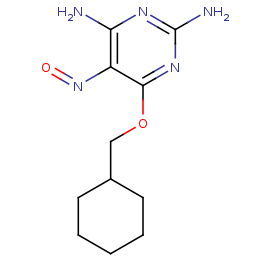

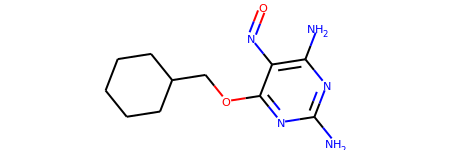

In [18]:
get_ligand_image('1e1x')

Lig                62K
Labels_conf    inact_b
Name: 4fkw, dtype: object
Peso molecular: 416.115
Número de electrones de valencia: 152 e
Volumen de la molécula: 389.960 A^3
SASA: 356.545 A^2
# de anillos: 3
# donadores de Hb: 3
# aceptores de Hb: 7

Descriptores usados por Ash & Fourches
Número de descriptores MACCS: 167
Número de descriptores 2D RDKit: 0
Número de descriptores WHIM: 114

Imagen obtenida del pdb: https://www.rcsb.org/ligand/62K


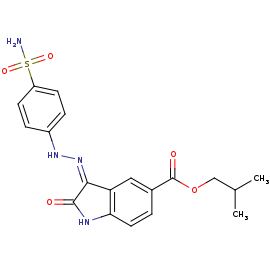

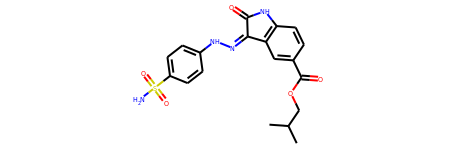

In [19]:
get_ligand_image('4fkw')

Lig               ATP
Labels_conf    active
Name: 1fin, dtype: object
Peso molecular: 502.967
Número de electrones de valencia: 174 e
Volumen de la molécula: 389.328 A^3
SASA: 353.232 A^2
# de anillos: 3
# donadores de Hb: 3
# aceptores de Hb: 18

Descriptores usados por Ash & Fourches
Número de descriptores MACCS: 167
Número de descriptores 2D RDKit: 0
Número de descriptores WHIM: 114

Imagen obtenida del pdb: https://www.rcsb.org/ligand/ATP


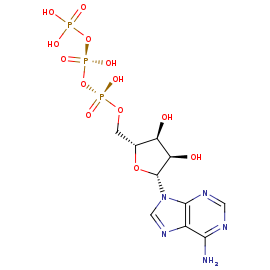

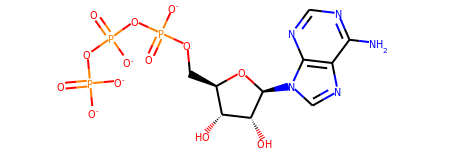

In [20]:
get_ligand_image('1fin')

Lig                ATP
Labels_conf    inact_a
Name: 1b38, dtype: object
Peso molecular: 502.967
Número de electrones de valencia: 174 e
Volumen de la molécula: 388.368 A^3
SASA: 350.478 A^2
# de anillos: 3
# donadores de Hb: 3
# aceptores de Hb: 18

Descriptores usados por Ash & Fourches
Número de descriptores MACCS: 167
Número de descriptores 2D RDKit: 0
Número de descriptores WHIM: 114

Imagen obtenida del pdb: https://www.rcsb.org/ligand/ATP


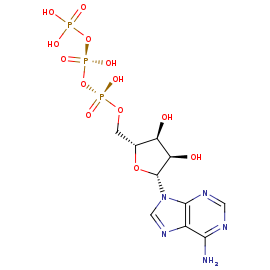

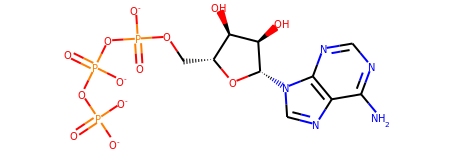

In [21]:
get_ligand_image('1b38')